In [1]:
import numpy as np 
import cv2
import os 
import pandas
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical,plot_model
import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

# Assigning the Global variables

In [2]:
DATA_DIR = "fight-detection-surv-dataset"
CLASS_NAMES = ["fight","noFight"]
SEQUENCE_LENGTH = 8
IMG_HEIGHT , IMG_WIDTH = 150,150
BATCHES = 32
CHANNELS = 3
INPUT_SHAPE = (SEQUENCE_LENGTH,IMG_HEIGHT,IMG_WIDTH,CHANNELS)
LABEL_POSITION = (10, 30) #(x,y)
LABEL_FONT = cv2.FONT_HERSHEY_SIMPLEX
LABEL_FONT_SIZE = 0.8
LABEL_COLOR = (0, 0, 255)  # White color in BGR
LABEL_THICKNESS = 2

# Extracting Features

In [5]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []
    for class_index,class_name in enumerate(CLASS_NAMES):
        print(class_name)
        files_path = os.listdir(os.path.join(DATA_DIR,class_name))
        for file_name in files_path:
            video_file_path = os.path.join(DATA_DIR,class_name,file_name)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)
    features = np.asarray(features)
    lables = np.array(labels)
    return features,labels,video_file_paths

In [7]:
def frame_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
        success,frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame,(IMG_HEIGHT,IMG_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return np.asarray(frames_list)
    

In [9]:
features,labels,video_file_paths = create_dataset()

fight
noFight


#### Converting the labels into One-Hot Encoded labels

In [44]:
encoded_labels = tf.keras.utils.to_categorical(labels)

#### Train-Test Split

In [46]:
from sklearn.model_selection import train_test_split
features_train,features_test,labels_train,labels_test = train_test_split(features,encoded_labels,test_size=0.3)

In [48]:
labels_train.shape

(210, 2)

# 3D_CNN Model

In [54]:
ThreeD_model = Sequential([  
    InputLayer(shape=(8,150,150,3)),
    
    Conv3D(filters=32,kernel_size=(2,2,2),activation="relu"),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(filters=64,kernel_size=(2,2,2),activation="relu"),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Conv3D(filters=128,kernel_size=(3,3,3),padding="same",activation="relu"),
    # MaxPooling3D(pool_size=(3, 3, 3)),

    Flatten(),
    
    Dense(units = 512, activation="relu"),
    Dense(units=2,activation="sigmoid")
])
ThreeD_model.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
# plot_model(ThreeD_model, to_file='3D_CNN_Model.png', show_shapes=True, show_layer_names=True)

In [56]:
ThreeD_model_history = ThreeD_model.fit(x = features_train,y = labels_train,epochs = 30, validation_data = (features_test,labels_test))
ThreeD_model.save("3D_CNN_Model.keras")

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - accuracy: 0.4951 - loss: 8.1976 - val_accuracy: 0.4778 - val_loss: 0.7396
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 629ms/step - accuracy: 0.5947 - loss: 0.6844 - val_accuracy: 0.5556 - val_loss: 0.6676
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 637ms/step - accuracy: 0.7285 - loss: 0.5677 - val_accuracy: 0.6778 - val_loss: 0.6745
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 641ms/step - accuracy: 0.7861 - loss: 0.4836 - val_accuracy: 0.6556 - val_loss: 0.6652
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - accuracy: 0.9117 - loss: 0.3684 - val_accuracy: 0.5667 - val_loss: 0.7676
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step - accuracy: 0.8446 - loss: 0.2890 - val_accuracy: 0.6556 - val_loss: 0.6553
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 640ms/step - accuracy: 0.9388 - loss: 0.2126 - val_accuracy: 0.6667 - val_loss: 0.6505
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 643ms/step - accuracy: 0.9741 - loss: 0.1313 - val_accuracy: 0.6222 - val_loss:

In [70]:
# plot_model(ThreeD_model, to_file='3D_CNN_Model.png', show_shapes=True, show_layer_names=True)
ThreeD_history = pd.DataFrame(ThreeD_model_history.history)
ThreeD_history.to_csv("ThreeD_model_history.csv")

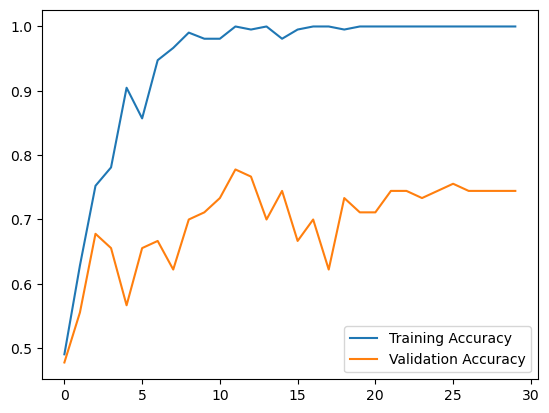

In [9]:
path = "Model History/ThreeD_model_history.csv"
history = pd.read_csv(path)
plt.plot( history["Unnamed: 0"] ,history["accuracy"], label = "Training Accuracy" )
plt.plot( history["Unnamed: 0"] , history["val_accuracy"], label = "Validation Accuracy" )
plt.legend()
plt.show()

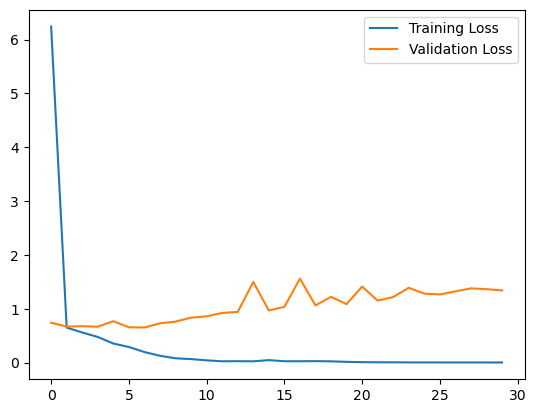

In [11]:
plt.plot( history["Unnamed: 0"] ,history["loss"], label = "Training Loss" )
plt.plot( history["Unnamed: 0"] , history["val_loss"], label = "Validation Loss" )
plt.legend()
plt.show()

# 3D_CNN + LSTM Model

In [72]:
ThreeD_CNN_model = Sequential([  
    InputLayer(shape=(8,150,150,3)),
    
    Conv3D(filters=32, kernel_size=(2, 2, 2), activation="relu"),
    MaxPooling3D(pool_size=(2,2,2)),
    Conv3D(filters=64, kernel_size=(2,2,2), activation="relu"),
    MaxPooling3D(pool_size=(2,2,2)),
    
    TimeDistributed(Flatten()),
    LSTM(units=64, return_sequences=True, activation="relu"),
    LSTM(units=32, return_sequences=False, activation="relu"),
    
    # Flatten(),
    
    Dense(units=512, activation="relu"),
    Dense(units=2, activation="sigmoid")
])

ThreeD_CNN_model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
# plot_model(ThreeD_CNN_model,to_file = "3D_CNN_LSTM_Model.png",show_shapes=True, show_layer_names=True)

In [74]:
ThreeD_CNN_model_history = ThreeD_CNN_model.fit(x = features_train,y = labels_train,epochs = 30,validation_data = (features_test,labels_test))

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 590ms/step - accuracy: 0.5262 - loss: 0.7041 - val_accuracy: 0.5889 - val_loss: 0.6915
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - accuracy: 0.6605 - loss: 0.6896 - val_accuracy: 0.5889 - val_loss: 0.6853
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - accuracy: 0.6200 - loss: 0.6792 - val_accuracy: 0.5556 - val_loss: 0.6819
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - accuracy: 0.6644 - loss: 0.6437 - val_accuracy: 0.4889 - val_loss: 0.7175
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.5673 - loss: 0.6628 - val_accuracy: 0.6111 - val_loss: 0.6520
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.7807 - loss: 0.5544 - val_accuracy: 0.6444 - val_loss: 0.6398
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - accuracy: 0.8312 - loss: 0.4146 - val_accuracy: 0.6778 - val_loss: 0.7018
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - accuracy: 0.9100 - loss: 0.2508 - val_accuracy: 0.6778 - val_loss:

In [78]:
ThreeD_CNN_model.save("3D_CNN_LSTM_Model.keras")

In [39]:
ThreeD_CNN_lstm_model_train_accuracy = ThreeD_CNN_model_history.history["accuracy"]
ThreeD_CNN_lstm_model_train_loss = ThreeD_CNN_model_history.history["loss"]
ThreeD_CNN_lstm_model_val_accuracy = ThreeD_CNN_model_history.history["val_accuracy"]
ThreeD_CNN_lstm_model_val_loss = ThreeD_CNN_model_history.history["val_loss"]

import pandas as pd
ThreeD_CNN_lstm_model_history = pd.DataFrame(ThreeD_CNN_model_history.history)
ThreeD_CNN_lstm_model_history.to_csv(path_or_buf = "3D_CNN_LSTM_History.csv") 

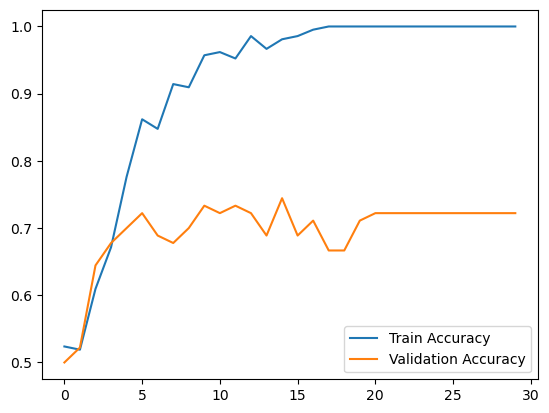

In [78]:
plt.plot(ThreeD_CNN_model_history.epoch,ThreeD_CNN_lstm_model_train_accuracy,label = "Train Accuracy")
plt.plot(ThreeD_CNN_model_history.epoch,ThreeD_CNN_lstm_model_val_accuracy, label = "Validation Accuracy")
plt.legend()
plt.show()

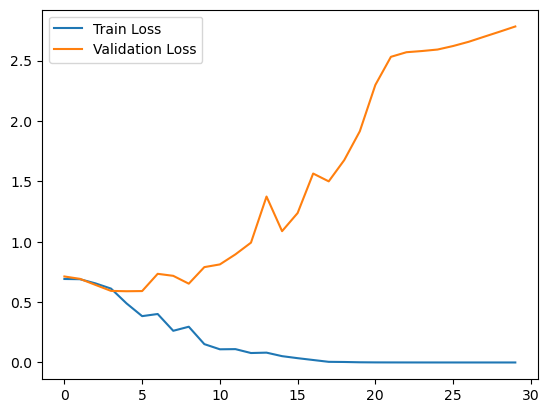

In [82]:
plt.plot(ThreeD_CNN_model_history.epoch,ThreeD_CNN_lstm_model_train_loss,label = "Train Loss")
plt.plot(ThreeD_CNN_model_history.epoch,ThreeD_CNN_lstm_model_val_loss, label = "Validation Loss")
plt.legend()
plt.show()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)